# Effect of Latranculin B and Nocodazole on the viscoelastic response of HL60 cells
Do full stress-strain curve analysis for experiments from October 2023

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from lmfit import Model, Parameters

from scripts.extensional_paras import fit_poly
from scripts.stress_hyper import (shear_stress_hyper_wc60_lc500_net_strain_ir_20240226,
                                  normal_stress_hyper_wc60_lc500_net_strain_ir_20240226,
                                  total_stress_hyper_wc60_lc500_net_strain_ir_20240226
                                  )

In [2]:
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=0.7, rc={'grid.linewidth': 0.5})

In [3]:
print("numpy v{}".format(np.__version__))
import matplotlib
print("matplotlib v{}".format(matplotlib.__version__))
print("pandas v{}".format(pd.__version__))
print("seaborn v{}".format(sns.__version__))
import lmfit
print("lmfit v{}".format(lmfit.__version__))

numpy v1.26.2
matplotlib v3.8.1
pandas v2.1.3
seaborn v0.13.0
lmfit v1.2.2


Versions 20231020:
```
numpy v1.25.2
matplotlib v3.7.1
pandas v2.0.3
seaborn v0.12.2
lmfit v1.2.2
```

In [4]:
sample_order = ['DMSO', 'LatB', 'Noco', 'LatB+Noco']

Functions for Kelvin-Voigt fit:

In [5]:
def kv_strain_poly_stress_from_int(t, lmbda, viscosity, strain_0, stress_poly, offset=0):
    strains = []
    for tt in t:
        x = np.linspace(0, tt, 100)
        integral = np.trapz(stress_poly(x) * np.exp(lmbda*x), x=x)
        sum_part_2 = integral / viscosity
        strains.append(np.exp(-lmbda * tt) * (strain_0 + sum_part_2) + offset)
    return strains

def kv_strain_poly_stress_from_int_global_p(t, lmbda, viscosity, strain_0,
                                            offset):
    global p
    strains = []
    for tt in t:
        x = np.linspace(0, tt, 100)
        integral = np.trapz(p(x) * np.exp(lmbda*x), x=x)
        sum_part_2 = integral / viscosity
        strains.append(np.exp(-lmbda * tt) * (strain_0 + sum_part_2) + offset)
    return strains

def fsize_cm(size_x, size_y):
    """
    
    :param size_x: Figure width in inch
    :param size_y: Figure height in inch
    :return: tuple(width, height) in cm
    """
    return size_x / 2.54, size_y / 2.54

### Read in median data
Median data created in notebook `20231020_get_median_HL60_LatB_Noco.ipynb`

In [6]:
save_med_path = "..\\data\\20231123_hl60_latb\\hl60_latb_noco_median_data_20240226.tsv"
df_median = pd.read_csv(save_med_path, sep='\t', index_col=0)
# kick out data from 20231019 because cells came from different batch
df_median = df_median.loc[df_median['date'] != 20231019]

In [7]:
extension_rate = df_median['extension_rate_fit']
pos_x = df_median['x_hyper']
pix_size = 0.68
diameter = 2 * np.sqrt(pix_size**2 * df_median['ell_major'] * df_median['ell_minor'])
df_median['diameter'] = diameter
flow_rate = df_median['flow_rate']

df_median['stress_net_ir'] \
    = total_stress_hyper_wc60_lc500_net_strain_ir_20240226(extension_rate,
                                                           pos_x,
                                                           diameter,
                                                           flow_rate)
df_median['shear_stress_net_ir'] \
    = shear_stress_hyper_wc60_lc500_net_strain_ir_20240226(pos_x,
                                                           diameter,
                                                           flow_rate)
df_median['normal_stress_net_ir'] \
    = normal_stress_hyper_wc60_lc500_net_strain_ir_20240226(extension_rate)

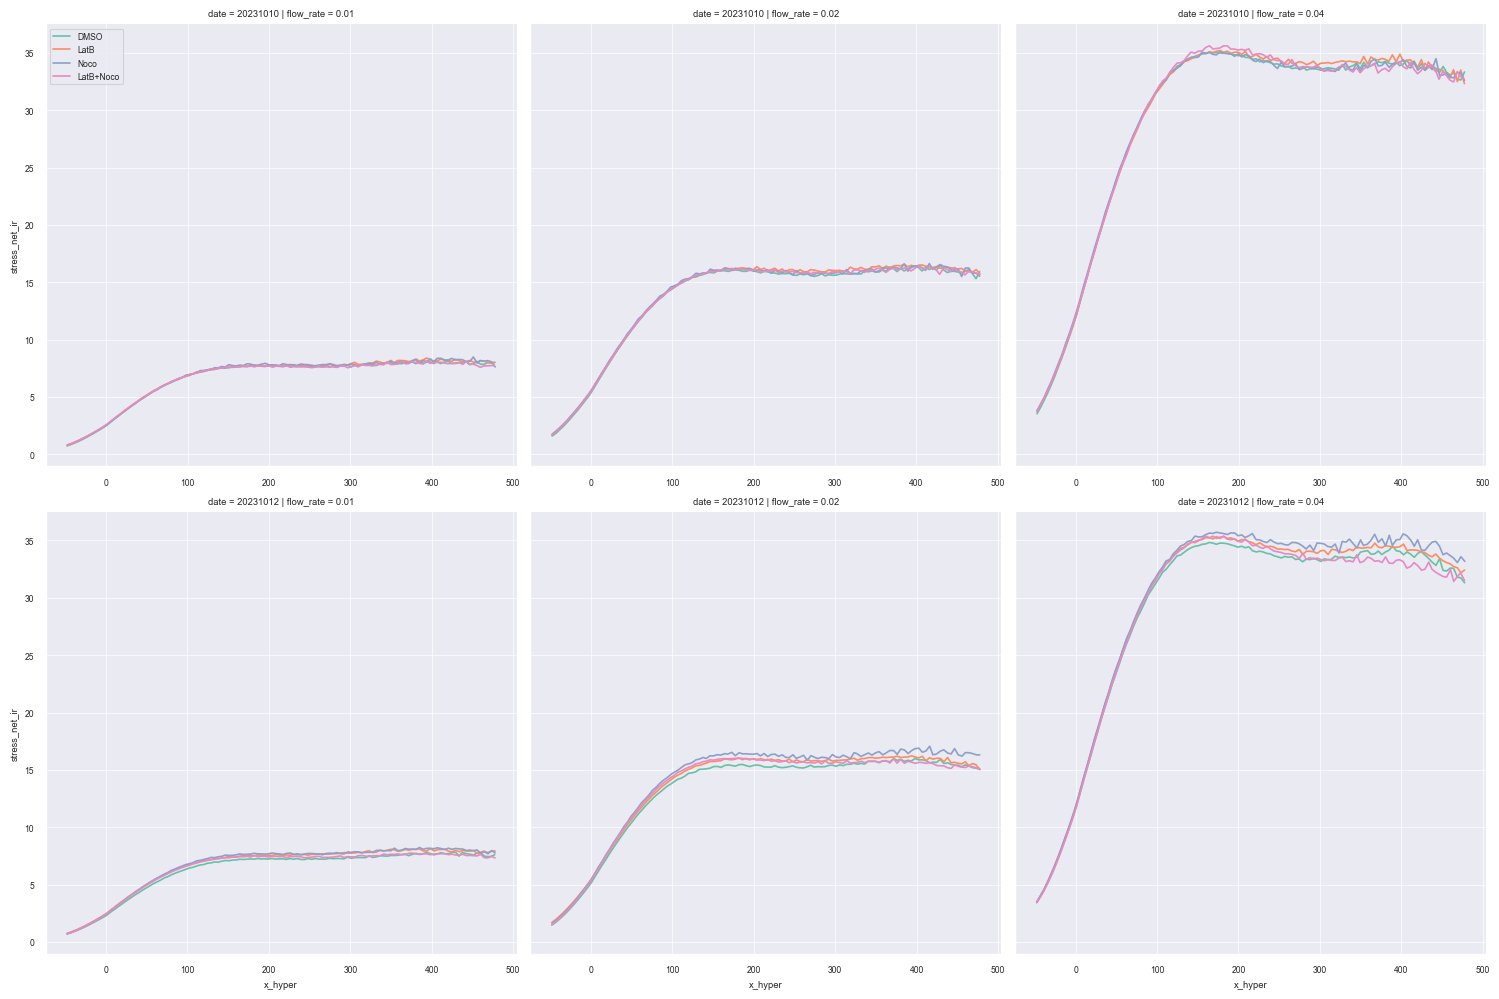

In [8]:
fct_kws = {'sharex': 'row', 'sharey': True, 'legend_out': False}
g = sns.relplot(data=df_median, x='x_hyper', y='stress_net_ir',
                hue='sample', hue_order=sample_order, palette='Set2',
                col='flow_rate', row='date',
                kind='line', facet_kws=fct_kws)
# g.refline(x=0, markersize=0, linestyle='--', linewidth=1, color='gray')
g.axes[0,0].legend(loc='upper left')
plt.show()

## Uncorrected net tensile strain from inertia ratio

In [9]:
x_feat = 'x_shift'
time_feat = 'time_shift'
strain_feat = 'net_strain_inert'
stress_feat = 'stress_net_ir'

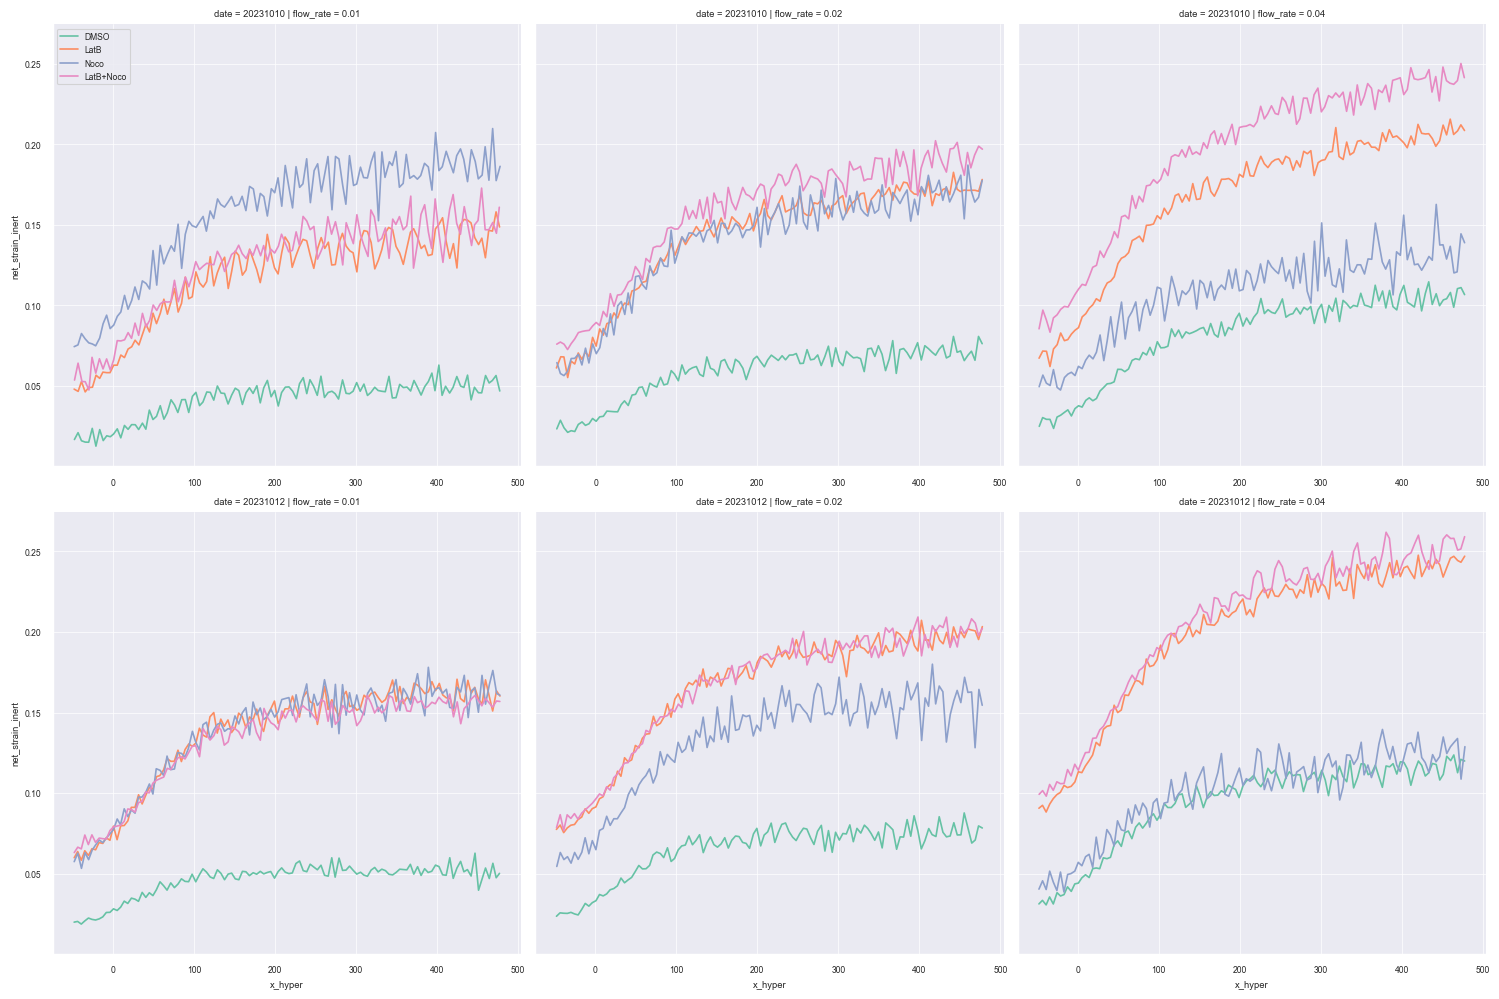

In [10]:
fct_kws = {'sharex': 'row', 'sharey': True, 'legend_out': False}
g = sns.relplot(data=df_median, x='x_hyper', y=strain_feat,
                hue='sample', hue_order=sample_order, palette='Set2',
                col='flow_rate', row='date',
                kind='line', facet_kws=fct_kws)
# g.refline(x=0, markersize=0, linestyle='--', linewidth=1, color='gray')
g.axes[0,0].legend(loc='upper left')
plt.show()

In [11]:
df_median['sample'].replace('DMSO', 'CTRL', inplace=True)
sample_order = ['CTRL', 'LatB', 'Noco', 'LatB+Noco']

##### Get stress functions

In [12]:
dates = df_median['date'].unique()
flow_rates = df_median['flow_rate'].unique()

stress_polys = {}

for date in dates:
    for fr in flow_rates:
        for sample in sample_order:
            df = df_median.loc[(df_median['date'] == date) 
                               & (df_median['flow_rate'] == fr) 
                               & (df_median['sample'] == sample)]
            if len(df) > 0:
                x = df[time_feat].to_numpy()
                y = df[stress_feat].to_numpy()
    
                key = f"{date}_{fr}_{sample}"
                stress_polys[key] = fit_poly(x, y, 8)

Fit KV model to the strain curves

In [13]:
df_kv_fit_ir = pd.DataFrame()
for date in tqdm(dates):
    for fr in tqdm(flow_rates, desc="Flow rates: "):
        for sample in sample_order:
            df = df_median.loc[(df_median['date'] == date)
                               & (df_median['flow_rate'] == fr)
                               & (df_median['sample'] == sample)]
            if len(df) > 0:
                time = df[time_feat].to_numpy()
                strain = df[strain_feat].to_numpy()
                # sort for time to get clean plot
                idx = np.argsort(time)
                time = time[idx]
                strain = strain[idx]
    
                # define parameters that the fit models will use
                params = Parameters()
                params.add('viscosity', value=2, min=0.01, max=20)
                params.add('lmbda', value=100, min=1, max=600)
                # construct max strain_0 and max offset based on the stress 
                # value at x_0
                # assume a minimum Young's modulus based of 80 Pa
                e_min = 80
                stress_0 = df[stress_feat].iloc[0]
                strain_0_max = stress_0 / e_min
                strain_0 = 0.5 * strain_0_max
                strain_0_min = 0.2 * strain_0
                params.add('strain_0', value=strain_0,
                           min=strain_0_min, max=strain_0_max)
                offset_0 = strain[:5].min()
                # offset_max = 1.2 * (offset_0 - strain_0_max)
                offset_max = 1.2 * offset_0
                if offset_max < 0.01:
                    offset_max = 0.01
                params.add('offset', value=offset_max/2, min=0, max=offset_max)
    
                # add stress polynomial factors
                key = f"{date}_{fr}_{sample}"
                p = stress_polys[key]
    
                # create fit model
                fmodel = Model(kv_strain_poly_stress_from_int_global_p)
    
                fit_result = fmodel.fit(strain, params, t=time, 
                                        nan_policy='omit', max_nfev=10000)
                df_fit_paras = pd.DataFrame()
                df_fit_paras['date'] = [date]
                df_fit_paras['flow_rate'] = [fr]
                df_fit_paras['sample'] = [sample]
                fit_paras = ['viscosity', 'lmbda', 'strain_0', 'offset']
                for ii, para in enumerate(fit_paras):
                    df_fit_paras[para] = [fit_result.best_values[para]]
                    df_fit_paras[para + '_err'] = fit_result.params[para].stderr
                    df_fit_paras[para + '_err_rel'] = (df_fit_paras[para + '_err'] 
                                                       / df_fit_paras[para])
                # add fit statistics to dataframe
                df_fit_paras['chisqr'] = fit_result.chisqr
                df_fit_paras['redchi'] = fit_result.redchi
                df_fit_paras['rsquared'] = fit_result.rsquared
                df_fit_paras['stress_0'] = stress_0
                
                df_kv_fit_ir = pd.concat([df_kv_fit_ir, df_fit_paras])
df_kv_fit_ir.reset_index(inplace=True, drop=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Flow rates:   0%|          | 0/3 [00:00<?, ?it/s]

Flow rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\AppData\Local\Temp\ipykernel_8368\2358489018.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_kv_fit_ir = pd.concat([df_kv_fit_ir, df_fit_paras])


In [14]:
visc = df_kv_fit_ir['viscosity']
visc_err = df_kv_fit_ir['viscosity_err']
lmbda = df_kv_fit_ir['lmbda']
lmbda_err = df_kv_fit_ir['lmbda_err']
df_kv_fit_ir['emodulus'] = visc * lmbda
df_kv_fit_ir['emodulus_err'] = np.sqrt((visc * lmbda_err) ** 2 + (lmbda * visc_err) ** 2)
df_kv_fit_ir['relaxation_time'] = 1 / lmbda
df_kv_fit_ir['relaxation_time_err'] = lmbda_err / lmbda ** 2
df_kv_fit_ir['strain_0_expect'] = df_kv_fit_ir['stress_0'] / df_kv_fit_ir['emodulus']

In [15]:
df_kv_fit_ir['sample'].replace('DMSO', 'CTRL', inplace=True)
df_kv_fit_ir 

date  flow_rate     sample  viscosity  viscosity_err  \
0   20231010       0.01       CTRL   1.196607       0.391438   
1   20231010       0.01       LatB   0.875424       0.187561   
2   20231010       0.01       Noco   0.843675       0.161636   
3   20231010       0.01  LatB+Noco   1.021602       0.215693   
4   20231010       0.02       CTRL   2.105026       0.386158   
5   20231010       0.02       LatB   1.076308       0.108917   
6   20231010       0.02       Noco   1.024156       0.169247   
7   20231010       0.02  LatB+Noco   1.234515       0.155272   
8   20231010       0.04       CTRL   2.433282       0.283468   
9   20231010       0.04       LatB   1.367275       0.119588   
10  20231010       0.04       Noco   2.278320       0.576071   
11  20231010       0.04  LatB+Noco   1.363500       0.118788   
12  20231012       0.01       CTRL   0.520619            NaN   
13  20231012       0.01       LatB   0.543549       0.080325   
14  20231012       0.01       Noco   0.637667       0.122830   
15  20231012       0.01  LatB+Noco   0.907721       0.104501   
16  20231012       0.02       CTRL   0.788406       0.226004   
17  20231012       0.02       LatB   0.969624       0.092710   
18  20231012       0.02       Noco   0.967222       0.184440   
19  20231012       0.02  LatB+Noco   1.210393       0.109455   
20  20231012       0.04       CTRL   1.683792       0.174649   
21  20231012       0.04       LatB   1.235794       0.100091   
22  20231012       0.04       Noco   2.089857       0.433458   
23  20231012       0.04  LatB+Noco   1.288716       0.108212   

    viscosity_err_rel       lmbda  lmbda_err  lmbda_err_rel  strain_0  ...  \
0            0.327123  171.027037  51.412026       0.300608  0.008558  ...   
1            0.214252   94.667301  17.139571       0.181051  0.000948  ...   
2            0.191586   82.591410  13.004343       0.157454  0.001022  ...   
3            0.211133   79.032469  13.576084       0.171779  0.001009  ...   
4            0.183446  153.053079  22.737928       0.148562  0.001995  ...   
5            0.101195  136.016029  11.158940       0.082041  0.002111  ...   
6            0.165255  144.578691  18.910754       0.130799  0.002207  ...   
7            0.125776  109.529457  10.939920       0.099881  0.002130  ...   
8            0.116496  170.324076  15.812236       0.092836  0.004421  ...   
9            0.087465  179.731511  12.554892       0.069854  0.004659  ...   
10           0.252849  181.682601  36.073042       0.198550  0.004703  ...   
11           0.087120  160.454470  11.120754       0.069308  0.004682  ...   
12                NaN  424.440612        NaN            NaN  0.000891  ...   
13           0.147778  132.077969  17.349523       0.131358  0.009176  ...   
14           0.192623  118.778136  19.732452       0.166129  0.000893  ...   
15           0.115124   90.187531   8.513226       0.094395  0.000897  ...   
16           0.286659  355.238629  92.147509       0.259396  0.004366  ...   
17           0.095614  134.619642  10.397515       0.077236  0.002120  ...   
18           0.190691  164.313288  25.565652       0.155591  0.002022  ...   
19           0.090430  107.352717   7.581015       0.070618  0.001906  ...   
20           0.103724  235.490149  19.307817       0.081990  0.004292  ...   
21           0.080993  182.471093  11.739399       0.064336  0.004360  ...   
22           0.207410  202.844379  33.767861       0.166472  0.004327  ...   
23           0.083969  167.373346  11.041656       0.065970  0.004304  ...   

    offset_err_rel    chisqr    redchi  rsquared  stress_0    emodulus  \
0         0.185966  0.002077  0.000018  0.867412  0.740904  204.652068   
1         0.113585  0.006285  0.000054  0.940963  0.758450   82.874002   
2         0.088447  0.008989  0.000077  0.942248  0.817774   69.680339   
3         0.116128  0.008066  0.000070  0.927454  0.807332   80.739749   
4         0.135243  0.001999  0.000017  0.930113  1.595985  322.180754   
5         0.

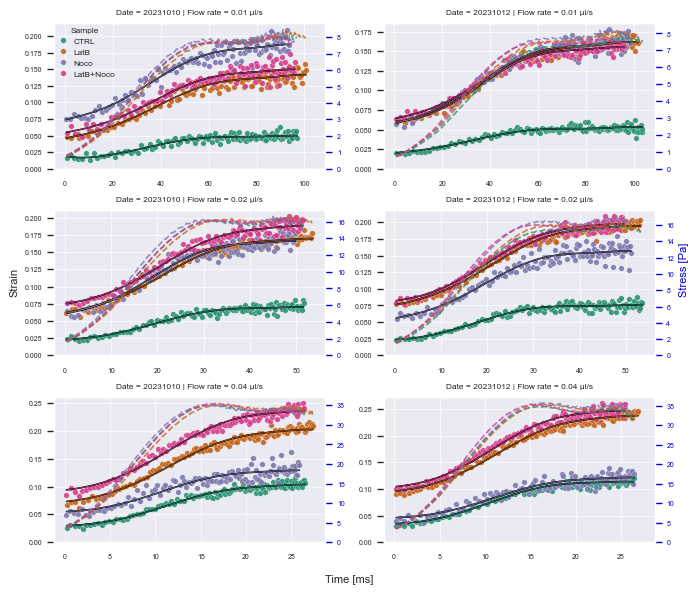

In [16]:
n_rows = len(flow_rates)
n_cols = len(dates)
colors = sns.color_palette('Dark2', len(sample_order), desat=0.8)
stress_color = 'mediumblue'
fsize = fsize_cm(17,15)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                         figsize=fsize, sharex='row')
# create array with twin axes
axes_tw = np.empty_like(axes)
for jj in range(n_rows):
    for ii in range(n_cols):
        ax = axes[jj, ii]
        axes_tw[jj, ii] = ax.twinx()

for ii, date in enumerate(dates):
    for jj, fr in enumerate(flow_rates):
        for ll, sample in enumerate(sample_order):
            idx = ((df_median['date'] == date)
                   & (df_median['flow_rate'] == fr)
                   & (df_median['sample'] == sample))
            df = df_median.loc[idx]
            
            ax = axes[jj, ii]
            ax.set_title("Date = {} | Flow rate = {} µl/s".format(date, fr),
                         fontsize=6)
            ax_tw = axes_tw[jj, ii]

            if len(df) > 0:
                x = df[time_feat].to_numpy()
                y = df[strain_feat].to_numpy()
                ax.plot(x *1e3, y, 'o', markersize=4, color=colors[ll], alpha=.9,
                        markeredgewidth=0.2, markeredgecolor='w',
                        label=sample, zorder=2)

                stress = df[stress_feat].to_numpy()
                ax_tw.plot(x *1e3, stress, '--', lw=1.2, color=colors[ll],
                           alpha=0.8, label="Stress", zorder=2)

                kv_paras = df_kv_fit_ir.loc[(df_kv_fit_ir['date'] == date)
                                            & (df_kv_fit_ir['flow_rate'] == fr)
                                            & (df_kv_fit_ir['sample'] == sample)
                ]
                if len(kv_paras) > 0:
                    key = "{}_{}_{}".format(date, fr, sample)
                    p = stress_polys[key]
                    y_kv = kv_strain_poly_stress_from_int(x,
                                                          kv_paras['lmbda'].iloc[0],
                                                          kv_paras['viscosity'].iloc[0],
                                                          kv_paras['strain_0'].iloc[0],
                                                          p,
                                                          offset=kv_paras['offset'].iloc[0])
                    ax.plot(x *1e3, y_kv, ls='-', c='k', lw=1.2, zorder=10)
                    ax.plot(x *1e3, y_kv, ls='-', c=colors[ll], lw=0.5, zorder=12)

for ii in range(n_rows):
    for jj in range(n_cols):
        ax = axes[ii, jj]
        ax.tick_params(labelsize=5)
        ax.set_ylim(0)
        ax_tw = axes_tw[ii, jj]
        ax_tw.tick_params(labelsize=5, color=stress_color, labelcolor=stress_color)
        ax_tw.grid()
        ax_tw.set_ylim(0)

axes[0, 0].legend(loc='upper left', bbox_to_anchor=[-0.015,1],
                  fontsize=6, 
                  frameon=False, handletextpad=0.3,
                  title="Sample", title_fontsize=6, #alignment='right',
                  borderpad=0, markerscale=1
                  )

label_fontsize=8
fig.supxlabel("Time [ms]", fontsize=label_fontsize)
fig.text(0, 0.5, "Strain", fontsize=label_fontsize, rotation=90, ha='center')
fig.text(1, 0.5, "Stress [Pa]", fontsize=label_fontsize, rotation=90, ha='center',
         color=stress_color)

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\SI\\fig_s7_hl60_latb_noco_strain_stress_time.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 200
            )

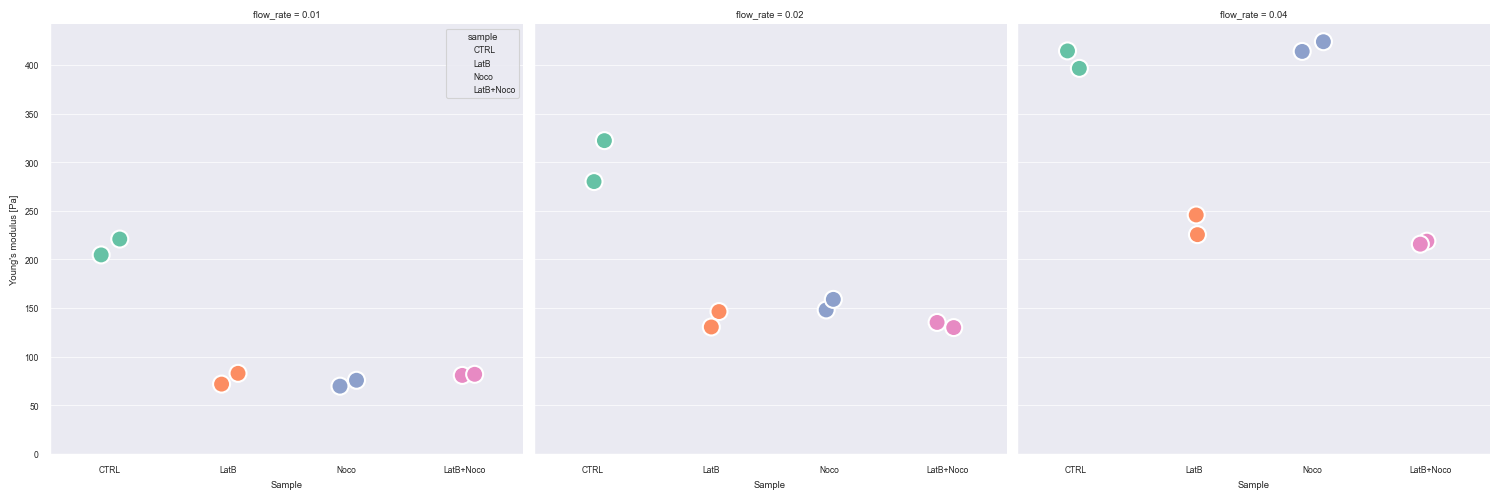

In [17]:
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='emodulus',
                hue='sample', hue_order=sample_order, palette='Set2',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, legend_out=False)
g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
g.set_ylabels('Young\'s modulus [Pa]')
plt.show()

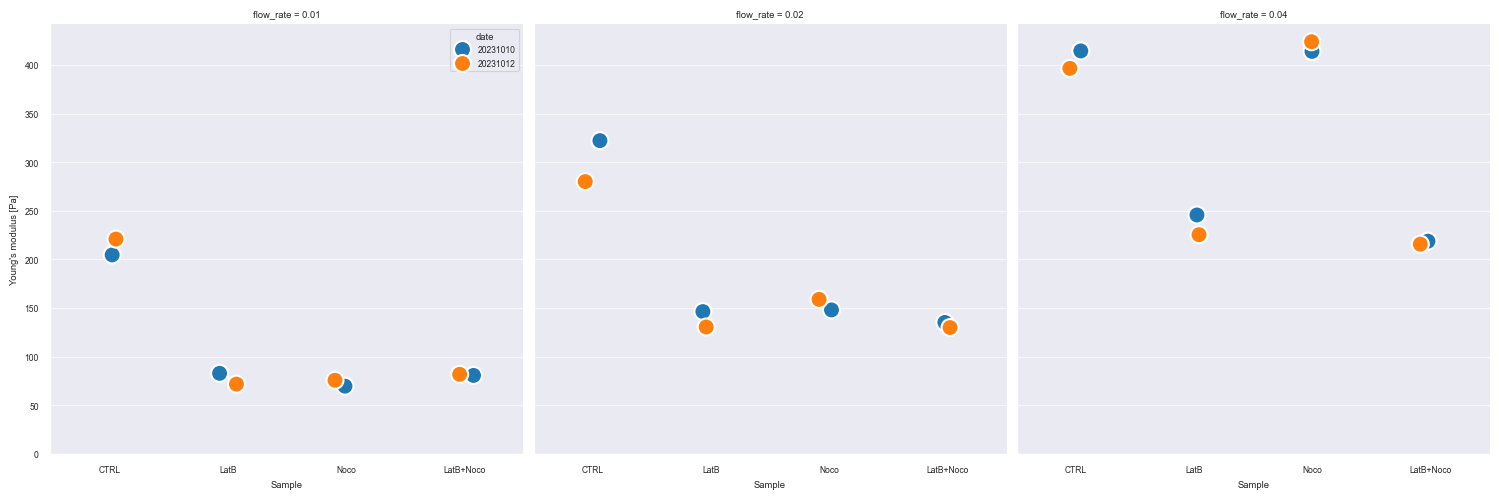

In [18]:
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='emodulus',
                hue='date', palette='tab10',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, 
                legend_out=False)
g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
g.set_ylabels('Young\'s modulus [Pa]')
plt.show()

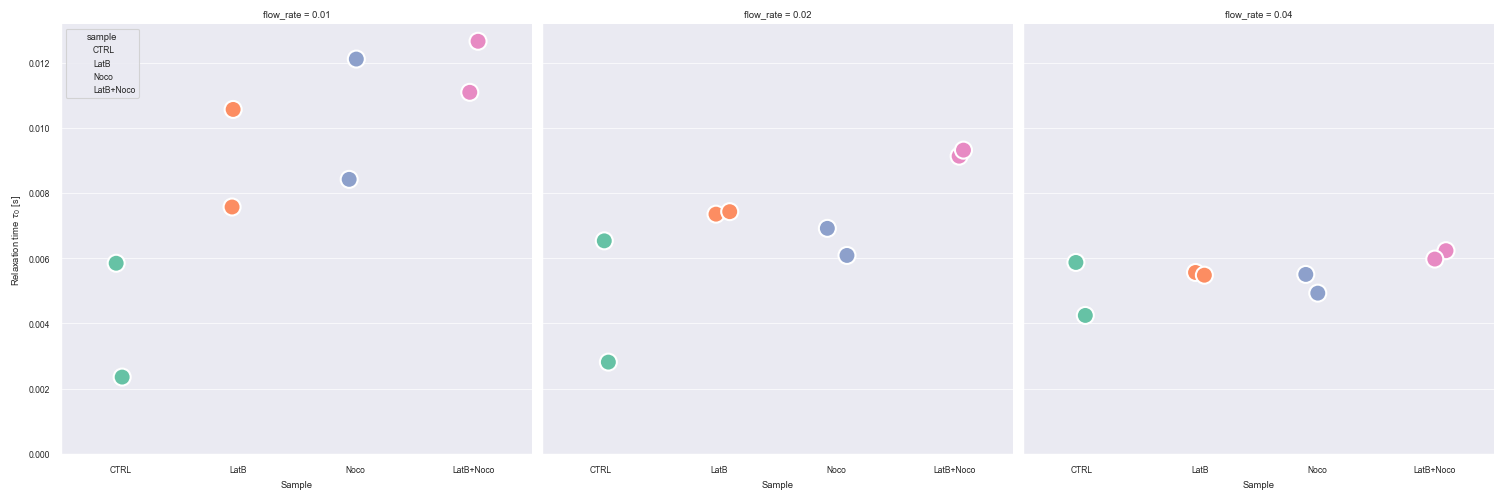

In [19]:
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='relaxation_time',
                hue='sample', hue_order=sample_order, palette='Set2',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, legend_out=False)
g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
g.set_ylabels(r'Relaxation time $\tau_0$ [s]')
plt.show()

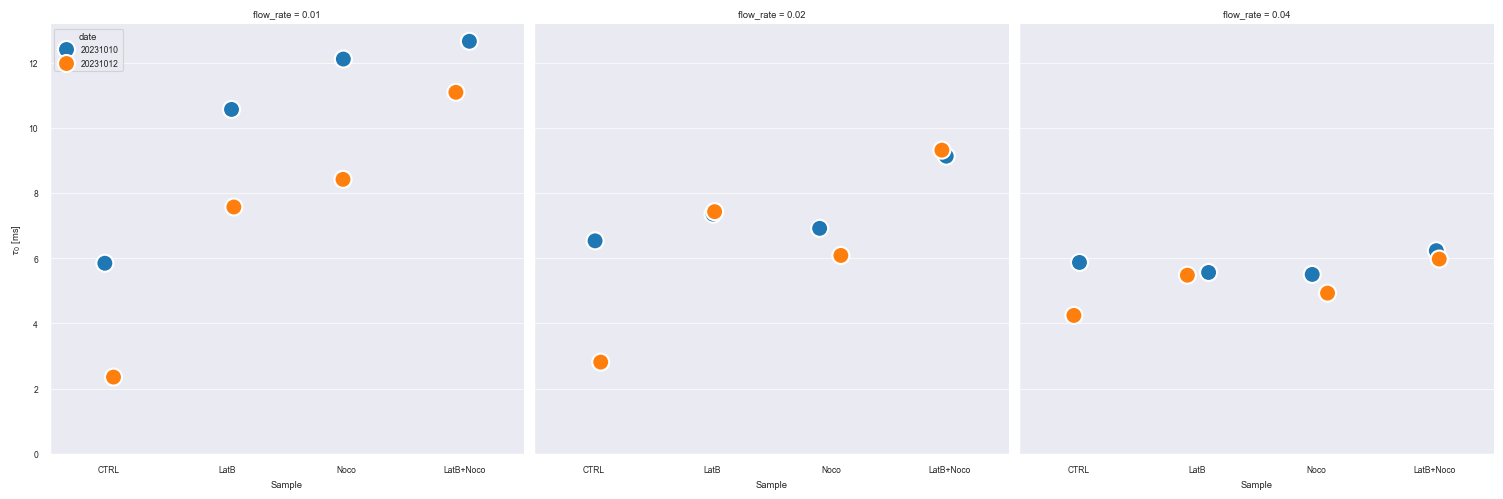

In [20]:
df_kv_fit_ir['tau [ms]'] = df_kv_fit_ir['relaxation_time'] * 1000
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='tau [ms]',
                hue='date', palette='tab10',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, legend_out=False)
g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
g.set_ylabels(r'$\tau_0$ [ms]')
plt.show()

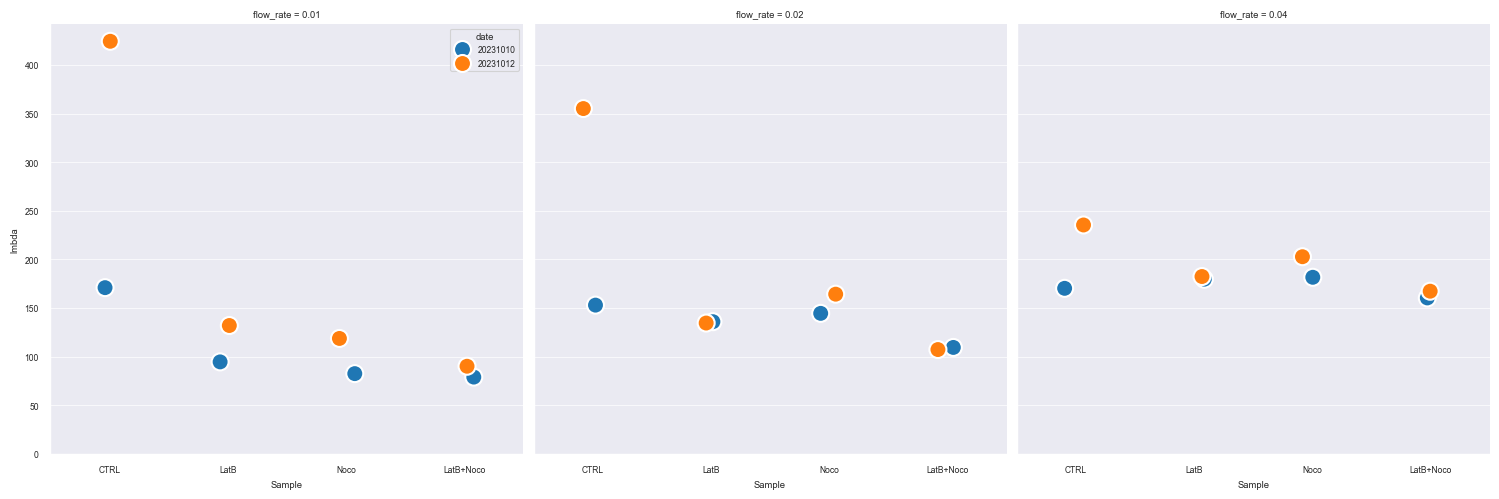

In [21]:
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='lmbda',
                hue='date', palette='tab10',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, legend_out=False)
g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
# g.set_ylabels(r'$\tau_0$ [s]')
plt.show()

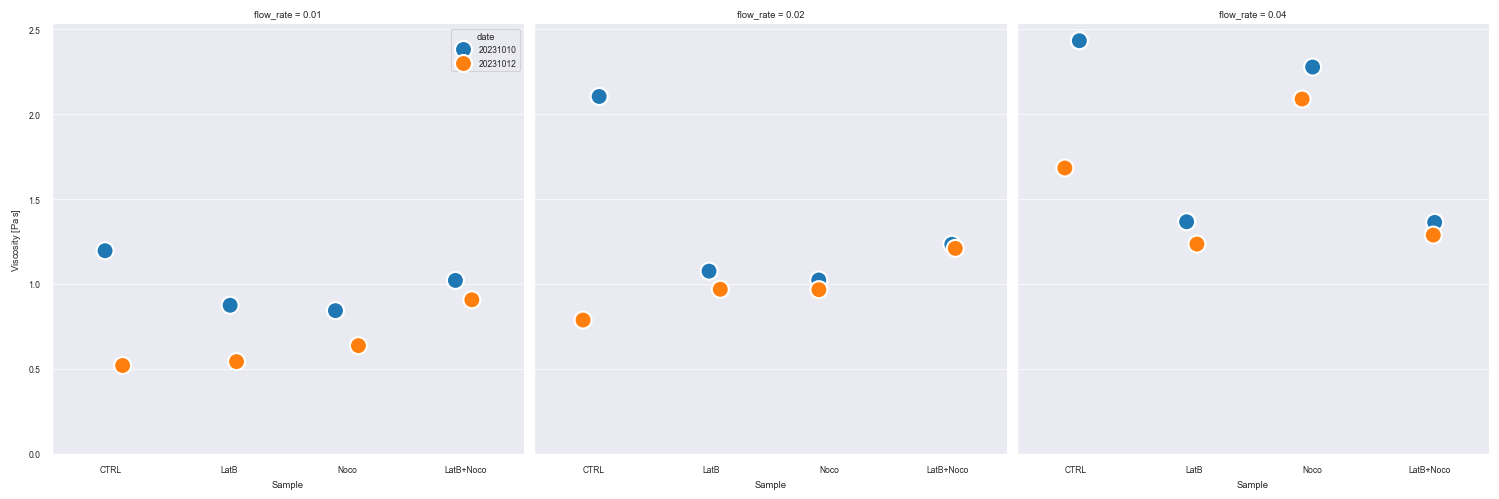

In [22]:
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='viscosity',
                hue='date', palette='tab10',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, legend_out=False)
g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
g.set_ylabels(r'Viscosity [Pa$\,$s]')
plt.show()

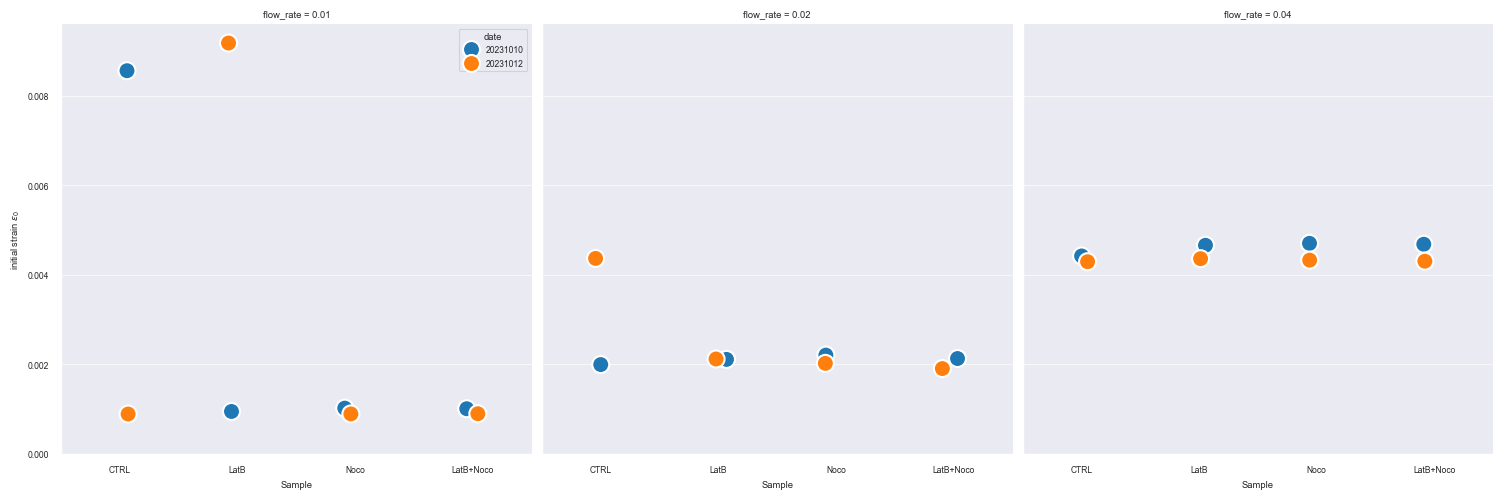

In [23]:
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='strain_0',
                hue='date', palette='tab10',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, legend_out=False)
g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
g.set_ylabels(r'initial strain $\varepsilon_0$')
plt.show()

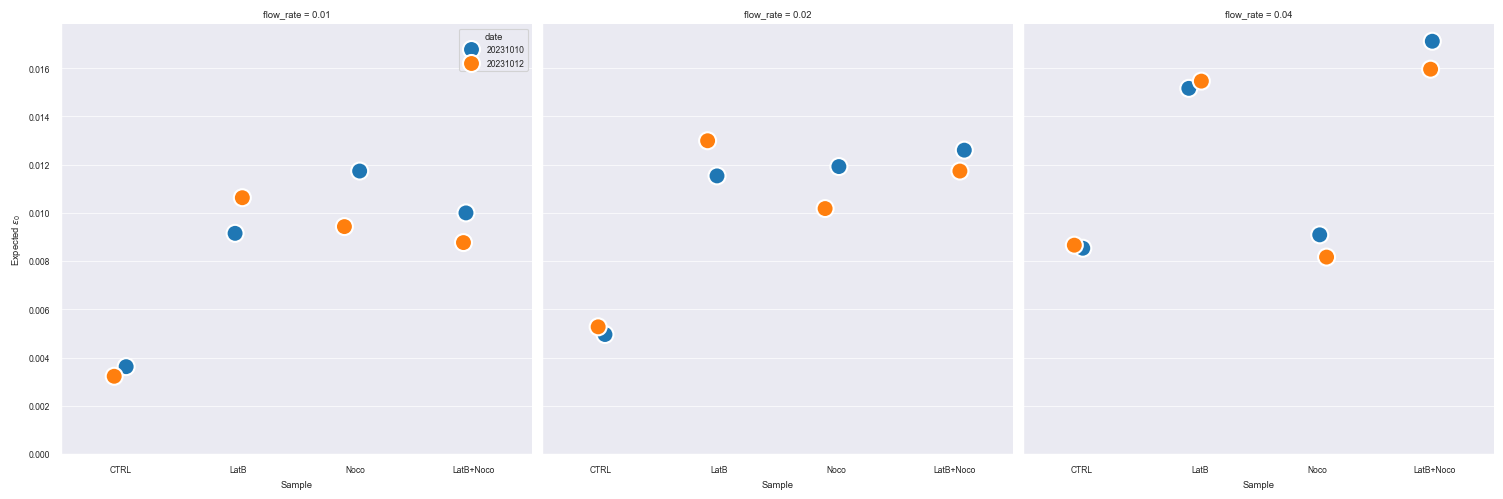

In [24]:
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='strain_0_expect',
                hue='date', palette='tab10',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, legend_out=False)
g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
g.set_ylabels(r'Expected $\varepsilon_0$')
plt.show()

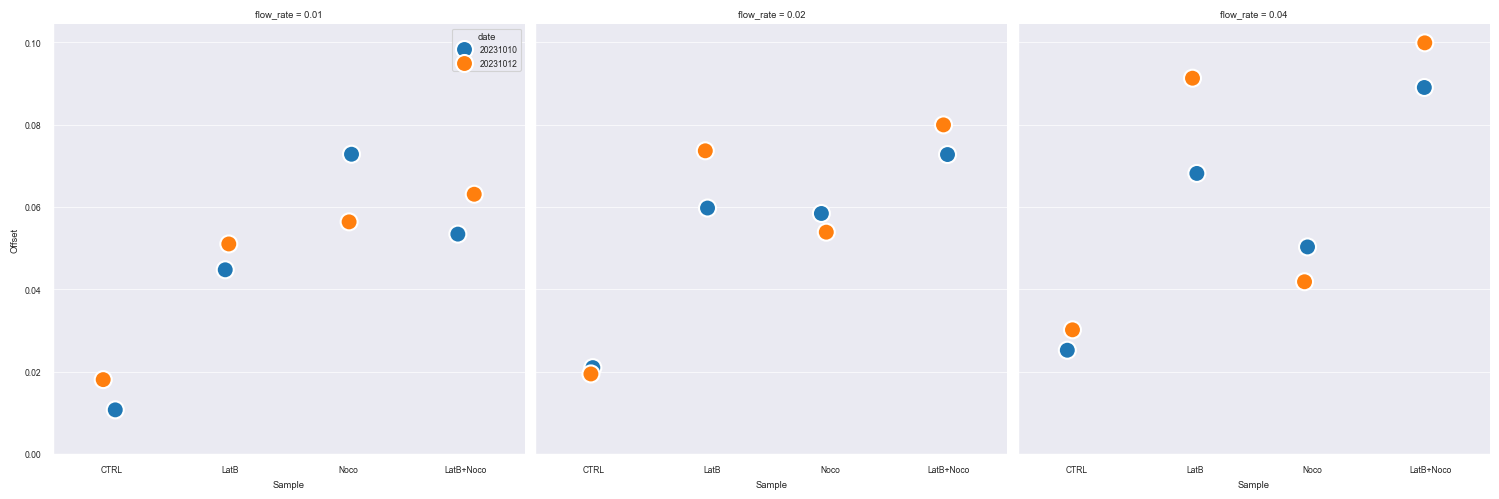

In [25]:
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='offset',
                hue='date', palette='tab10',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, legend_out=False)
g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
g.set_ylabels(r'Offset')
plt.show()

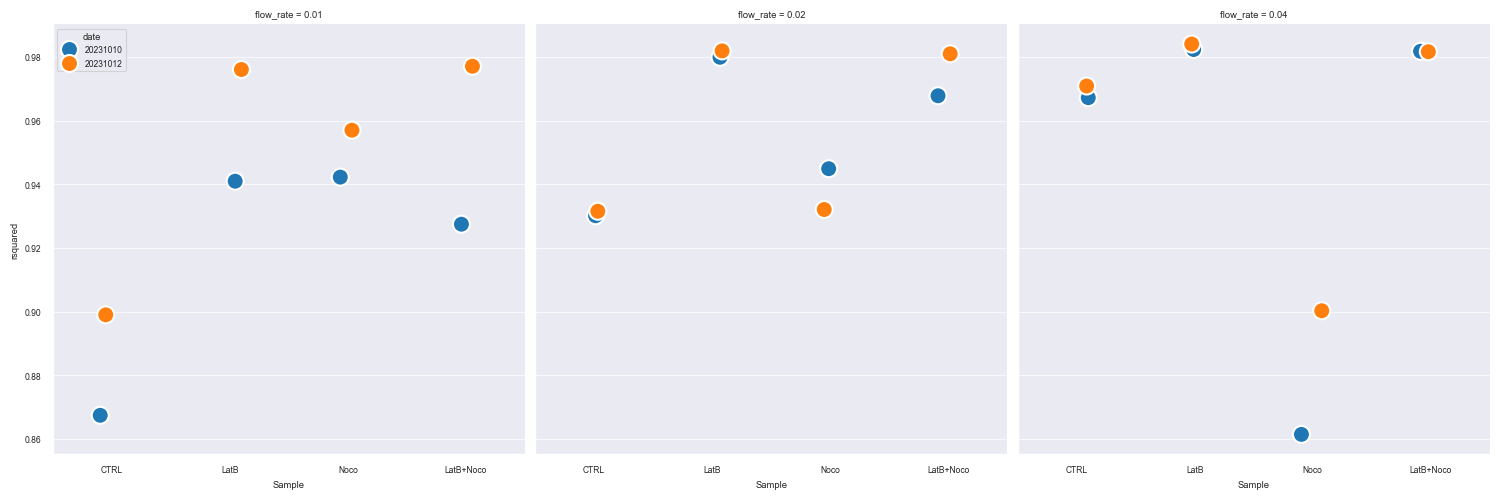

In [26]:
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='rsquared',
                hue='date', palette='tab10',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, legend_out=False)
# g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
# g.set_ylabels(r'Offset')
plt.show()

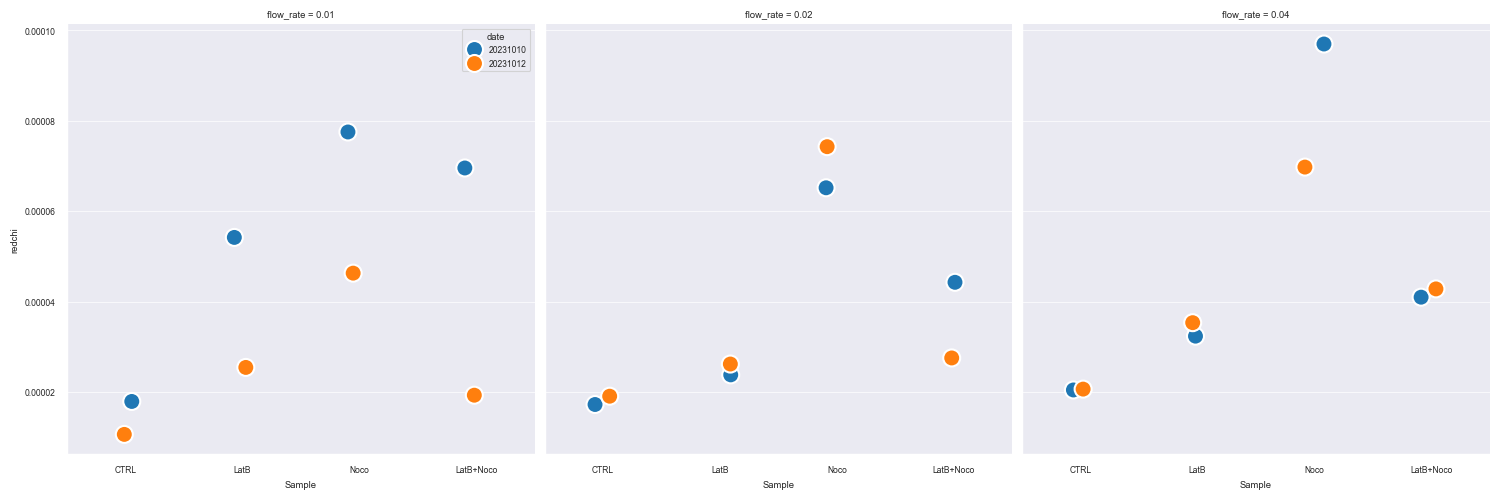

In [27]:
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='redchi',
                hue='date', palette='tab10',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, legend_out=False)
# g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
# g.set_ylabels(r'Offset')
plt.show()

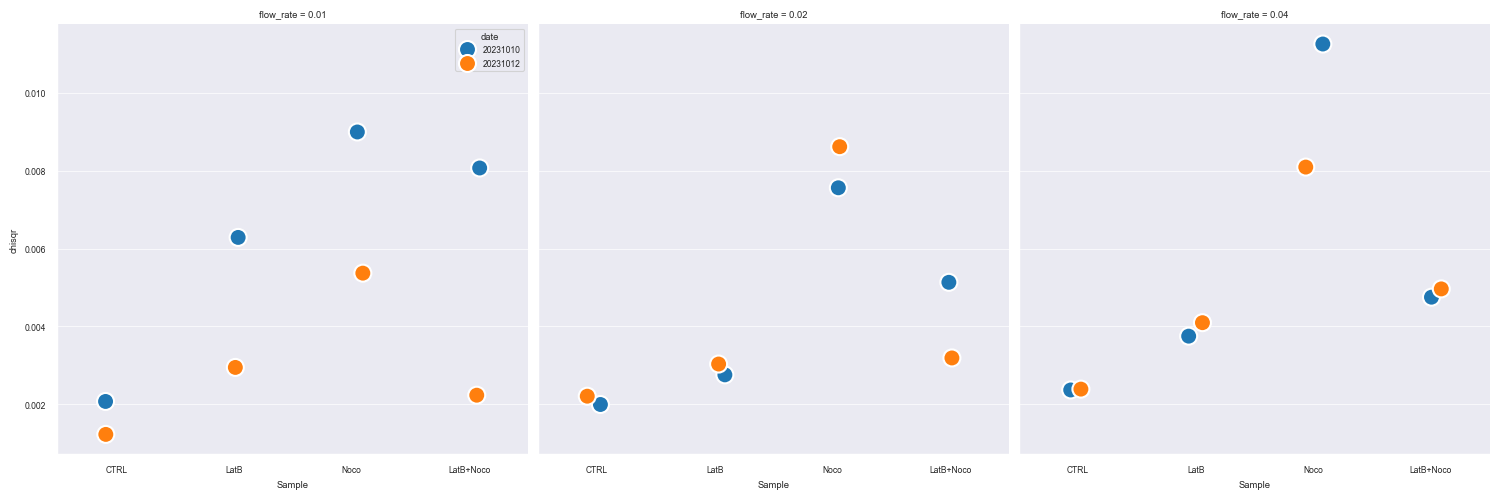

In [28]:
g = sns.catplot(data=df_kv_fit_ir, x='sample', y='chisqr',
                hue='date', palette='tab10',
                col='flow_rate',
                kind='strip', s=150, edgecolor='w', linewidth=1.5,
                sharey=True, legend_out=False)
# g.axes[0,0].set_ylim(0)
g.set_xlabels('Sample')
# g.set_ylabels(r'Offset')
plt.show()

### Prepare plots for publication

Exclude data for 20231019 because these cells came from a threshly thawed batch of cells while the others underwent 10+ passages before measurement

In [29]:
df_kv_publication =  df_kv_fit_ir.loc[df_kv_fit_ir['date'] != 20231019]
df_kv_publication['relaxation time [ms]'] = df_kv_publication['relaxation_time'] *1e3
df_kv_publication

date  flow_rate     sample  viscosity  viscosity_err  \
0   20231010       0.01       CTRL   1.196607       0.391438   
1   20231010       0.01       LatB   0.875424       0.187561   
2   20231010       0.01       Noco   0.843675       0.161636   
3   20231010       0.01  LatB+Noco   1.021602       0.215693   
4   20231010       0.02       CTRL   2.105026       0.386158   
5   20231010       0.02       LatB   1.076308       0.108917   
6   20231010       0.02       Noco   1.024156       0.169247   
7   20231010       0.02  LatB+Noco   1.234515       0.155272   
8   20231010       0.04       CTRL   2.433282       0.283468   
9   20231010       0.04       LatB   1.367275       0.119588   
10  20231010       0.04       Noco   2.278320       0.576071   
11  20231010       0.04  LatB+Noco   1.363500       0.118788   
12  20231012       0.01       CTRL   0.520619            NaN   
13  20231012       0.01       LatB   0.543549       0.080325   
14  20231012       0.01       Noco   0.637667       0.122830   
15  20231012       0.01  LatB+Noco   0.907721       0.104501   
16  20231012       0.02       CTRL   0.788406       0.226004   
17  20231012       0.02       LatB   0.969624       0.092710   
18  20231012       0.02       Noco   0.967222       0.184440   
19  20231012       0.02  LatB+Noco   1.210393       0.109455   
20  20231012       0.04       CTRL   1.683792       0.174649   
21  20231012       0.04       LatB   1.235794       0.100091   
22  20231012       0.04       Noco   2.089857       0.433458   
23  20231012       0.04  LatB+Noco   1.288716       0.108212   

    viscosity_err_rel       lmbda  lmbda_err  lmbda_err_rel  strain_0  ...  \
0            0.327123  171.027037  51.412026       0.300608  0.008558  ...   
1            0.214252   94.667301  17.139571       0.181051  0.000948  ...   
2            0.191586   82.591410  13.004343       0.157454  0.001022  ...   
3            0.211133   79.032469  13.576084       0.171779  0.001009  ...   
4            0.183446  153.053079  22.737928       0.148562  0.001995  ...   
5            0.101195  136.016029  11.158940       0.082041  0.002111  ...   
6            0.165255  144.578691  18.910754       0.130799  0.002207  ...   
7            0.125776  109.529457  10.939920       0.099881  0.002130  ...   
8            0.116496  170.324076  15.812236       0.092836  0.004421  ...   
9            0.087465  179.731511  12.554892       0.069854  0.004659  ...   
10           0.252849  181.682601  36.073042       0.198550  0.004703  ...   
11           0.087120  160.454470  11.120754       0.069308  0.004682  ...   
12                NaN  424.440612        NaN            NaN  0.000891  ...   
13           0.147778  132.077969  17.349523       0.131358  0.009176  ...   
14           0.192623  118.778136  19.732452       0.166129  0.000893  ...   
15           0.115124   90.187531   8.513226       0.094395  0.000897  ...   
16           0.286659  355.238629  92.147509       0.259396  0.004366  ...   
17           0.095614  134.619642  10.397515       0.077236  0.002120  ...   
18           0.190691  164.313288  25.565652       0.155591  0.002022  ...   
19           0.090430  107.352717   7.581015       0.070618  0.001906  ...   
20           0.103724  235.490149  19.307817       0.081990  0.004292  ...   
21           0.080993  182.471093  11.739399       0.064336  0.004360  ...   
22           0.207410  202.844379  33.767861       0.166472  0.004327  ...   
23           0.083969  167.373346  11.041656       0.065970  0.004304  ...   

      redchi  rsquared  stress_0    emodulus  emodulus_err  relaxation_time  \
0   0.000018  0.867412  0.740904  204.652068     90.920456         0.005847   
1   0.000054  0.940963  0.758450   82.874002     23.246586         0.010563   
2   0.000077  0.942248  0.817774   69.680339     17.279707         0.012108   
3   0.000070  0.927454  0.807332   80.739749     21.976170         0.012653   
4   0.000017  0.930113  1.595985  322.180754     76.053113   

In [30]:
markersize = 4
linewidth = 1.5
markeredgewidth = 0.4

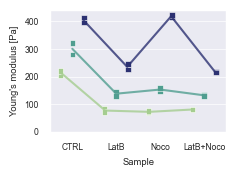

In [31]:
y_feat = 'emodulus'

fsize = fsize_cm(6, 4.5)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.stripplot(data=df_kv_publication, x='sample', y=y_feat,
              hue='flow_rate', palette='crest',
              # style='sample', style_order=sample_order,
              dodge=True, jitter=False,
              marker='s', s=markersize, edgecolor='w', linewidth=markeredgewidth,
              legend=False, ax=ax, zorder=1)
sns.pointplot(data=df_kv_publication, x='sample', y=y_feat,
              hue='flow_rate', palette='crest',
              estimator=np.mean,
              dodge=0.5, marker=None, errorbar=None,
              linewidth=linewidth, alpha=0.8,
              legend=False, ax=ax, zorder=2
              )
ax.set_ylim(0)
ax.set_xlabel("Sample")
ax.set_ylabel("Young\'s modulus [Pa]")

# ax.legend(title="Flow rate [µL/s]", title_fontsize=6,
#           fontsize=6,
#           loc='lower center', bbox_to_anchor=[0.5, 1],
#           ncol=3, columnspacing=0.8
#           )

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig5_noco_emodulus.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

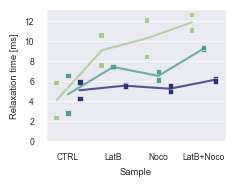

In [32]:
y_feat = 'relaxation time [ms]'

fsize = fsize_cm(6, 4.75)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.stripplot(data=df_kv_publication, x='sample', y=y_feat,
              hue='flow_rate', palette='crest',
              dodge=True, jitter=False,
              marker='s', s=markersize, edgecolor='w', linewidth=markeredgewidth,
              legend=False, ax=ax, zorder=1)
sns.pointplot(data=df_kv_publication, x='sample', y=y_feat,
              hue='flow_rate', palette='crest',
              estimator=np.mean, 
              dodge=0.5, marker=None, errorbar=None,
              linewidth=linewidth, alpha=0.8,
              legend=False, ax=ax, zorder=2
              )
ax.set_ylim(0)
ax.set_xlabel("Sample")
ax.set_ylabel("Relaxation time [ms]")

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig5_noco_relaxation_time.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

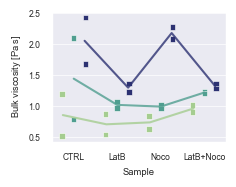

In [33]:
y_feat = 'viscosity'

fsize = fsize_cm(6, 4.75)
fig, ax = plt.subplots(1, 1, figsize=fsize)

sns.stripplot(data=df_kv_publication, x='sample', y=y_feat,
              hue='flow_rate', palette='crest',
              dodge=True, jitter=False,
              marker='s', s=markersize, edgecolor='w', linewidth=markeredgewidth,
              legend=False, ax=ax, zorder=1)
sns.pointplot(data=df_kv_publication, x='sample', y=y_feat,
              hue='flow_rate', palette='crest',
              estimator=np.mean,
              dodge=0.5, marker=None, errorbar=None,
              linewidth=linewidth, alpha=0.8,
              legend=False, ax=ax, zorder=2
              )
# ax.set_ylim(0)
ax.set_xlabel("Sample")
ax.set_ylabel("Bulk viscosity [Pa$\,$s]")

plt.tight_layout()
plt.show()

save_path = "..\\figure_plots\\fig5_noco_viscosity.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )

## Plot strain correction at inlet

In [34]:
data_folder = os.path.join("..", "data", "20231123_hl60_latb", "inlet_latb_noco")

path_20231010_inlet = os.path.join(data_folder,
                                   "20231010_hl60_latb_noco_inlet.tsv")
df_20231010_inlet = pd.read_csv(path_20231010_inlet, sep='\t', index_col=0)

path_20231012_inlet = os.path.join(data_folder,
                                   "20231012_hl60_latb_noco_inlet.tsv")
df_20231012_inlet = pd.read_csv(path_20231012_inlet, sep='\t', index_col=0)

In [35]:
df_inlet_all = pd.concat([df_20231010_inlet,
                          df_20231012_inlet
                          ], ignore_index=True)
df_inlet_all['date'] = df_inlet_all['date'].astype(int)

In [36]:
df_inlet_all['net_strain_inert'] = ((df_inlet_all['inert_ratio_raw'] - 1)
                                    / np.sqrt(df_inlet_all['inert_ratio_raw']))

In [37]:
x_feat = 'pos_x'
n_bins = 120
# need to iterate over all dates, concentrations
# to create bins then concatenate to big dataframe again
df_median_inlet = pd.DataFrame()
dates = df_inlet_all['date'].unique()
for date in dates:
    df_date = df_inlet_all.loc[df_inlet_all['date'] == date]
    for concentration in df_date['sample'].unique():
        df_cc = df_date.loc[df_date['sample'] == concentration]
        bins = pd.cut(df_cc[x_feat], n_bins)
        df_grouped = df_cc.groupby(by=['sample', bins],
                                   as_index=False, observed=False
                                   )
        df_median_inlet = pd.concat([df_median_inlet, df_grouped.median()], ignore_index=True)
df_median_inlet.reset_index(inplace=True, drop=True)

In [38]:
df_median_inlet['sample'].replace(to_replace={'DMSO': 'CTRL',
                                              '1uM_Noco': 'Noco',
                                              '250nM_LatB': 'LatB',
                                              '250nM_LatB_1uM_Noco': 'LatB+Noco'
                                              },
                                  inplace=True)
df_median_inlet['date'] = df_median_inlet['date'].astype(int)

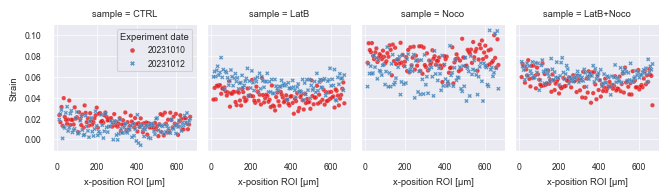

In [39]:
fsize = fsize_cm(17, 5)
n_cols = df_median_inlet['sample'].unique().size
aspect = fsize[0] / (fsize[1] * n_cols)
g = sns.relplot(data=df_median_inlet, x='x_inlet', y='net_strain_inert',
                height=fsize[1], aspect=aspect,
                hue='date', palette='Set1', alpha=0.8,
                style='date',
                col='sample', col_wrap=n_cols, col_order=sample_order,
                kind='scatter', s=10, linewidth=0.1,
                facet_kws={'legend_out': False})
g.set_xlabels("x-position ROI [µm]")
g.set_ylabels("Strain")

ax0 = g.axes[0]
ax0.legend(title="Experiment date")

# plt.tight_layout()
plt.show()

fig = g.figure
save_path = "..\\figure_plots\\SI\\fig_s5_latb_noco_inlet.pdf"
fig.savefig(save_path, format='pdf', dpi=900,
            bbox_inches='tight', pad_inches=fsize[0] / 50
            )